# train XGBosst and keep the model selection rank

In [1]:
#external libraries
import os
import dotenv
import pandas as pd
import numpy as np
from scipy import signal as sg
import pickle as pkl
import time
import matplotlib.pyplot as plt

#project library
from spinco import *

#environment variables
dotenv.load_dotenv('lab.env')

#project variables
datapath=os.environ['DATAPATH']

In [2]:
#define features path
dreamspath=datapath+"/DREAMS"
featurespath=dreamspath+"/features"
        
windowDurations=[0.5,1,1.5,2]

## Load data

In [3]:
signals, annotations, signalsMetadata = loadDREAMSSpindles(dreamspath)

SubjectId: 0001--------------
resampling from 100 to 200
SubjectId: 0003--------------
resampling from 50 to 200
SubjectId: 0006--------------
duration discrepancy, removing last 0.7 seconds


In [4]:
signalsMetadata.head(5)

,filename,channel,subjectId,duration,samplerate,database
0,excerpt1.txt,C3-A1,0001,1800,200,DREAMS
1,excerpt2.txt,CZ-A1,0002,1800,200,DREAMS
2,excerpt3.txt,C3-A1,0003,1800,200,DREAMS
3,excerpt4.txt,CZ-A1,0004,1800,200,DREAMS
4,excerpt5.txt,CZ-A1,0005,1800,200,DREAMS


## Load features

In [5]:
windowDurations

[0.5, 1, 1.5, 2]

In [6]:
featureDf=pd.DataFrame()

durationFolders=os.listdir(dreamspath+'/features/200fs')
for duration in durationFolders:
    subjectFolders=os.listdir(dreamspath+'/features/200fs/'+duration)
    for subject in subjectFolders:
        aux=os.listdir(dreamspath+'/features/200fs/'+duration+'/'+subject)
        thisFeatureDf=pd.DataFrame({
            'filename':aux
        })
        featureDf=pd.concat([featureDf,thisFeatureDf],axis=0)

In [7]:
featureDf

,filename
0,0.5_0001_hjortActivity_alpha.fd
1,0.5_0001_hjortActivity_beta1.fd
2,0.5_0001_hjortActivity_beta2.fd
3,0.5_0001_hjortActivity_broadband.fd
4,0.5_0001_hjortActivity_delta1.fd
...,...
28,2_0008_petrosian_delta1.fd
29,2_0008_petrosian_delta2.fd
30,2_0008_petrosian_sigma.fd
31,2_0008_petrosian_theta.fd


In [8]:
featureDf['window']=featureDf.apply(lambda row:
                                    row.filename.split('_')[0],axis=1)
featureDf['subjectId']=featureDf.apply(lambda row:
                                    row.filename.split('_')[1],axis=1)
featureDf['characteristic']=featureDf.apply(lambda row:
                                    row.filename.split('_')[2],axis=1)
featureDf['bandName']=featureDf.apply(lambda row:
                                    row.filename.split('_')[3].split('.')[0],axis=1)

In [9]:
featureDf

,filename,window,subjectId,characteristic,bandName
0,0.5_0001_hjortActivity_alpha.fd,0.5,0001,hjortActivity,alpha
1,0.5_0001_hjortActivity_beta1.fd,0.5,0001,hjortActivity,beta1
2,0.5_0001_hjortActivity_beta2.fd,0.5,0001,hjortActivity,beta2
3,0.5_0001_hjortActivity_broadband.fd,0.5,0001,hjortActivity,broadband
4,0.5_0001_hjortActivity_delta1.fd,0.5,0001,hjortActivity,delta1
...,...,...,...,...,...
28,2_0008_petrosian_delta1.fd,2,0008,petrosian,delta1
29,2_0008_petrosian_delta2.fd,2,0008,petrosian,delta2
30,2_0008_petrosian_sigma.fd,2,0008,petrosian,sigma
31,2_0008_petrosian_theta.fd,2,0008,petrosian,theta


In [10]:
uniqueFeature=featureDf[['window','characteristic','bandName']].drop_duplicates(ignore_index=True)

In [11]:
signalsMetadata.head()

,filename,channel,subjectId,duration,samplerate,database
0,excerpt1.txt,C3-A1,0001,1800,200,DREAMS
1,excerpt2.txt,CZ-A1,0002,1800,200,DREAMS
2,excerpt3.txt,C3-A1,0003,1800,200,DREAMS
3,excerpt4.txt,CZ-A1,0004,1800,200,DREAMS
4,excerpt5.txt,CZ-A1,0005,1800,200,DREAMS


In [13]:
uniqueFeature

,window,characteristic,bandName
0,0.5,hjortActivity,alpha
1,0.5,hjortActivity,beta1
2,0.5,hjortActivity,beta2
3,0.5,hjortActivity,broadband
4,0.5,hjortActivity,delta1
...,...,...,...
127,2,petrosian,delta1
128,2,petrosian,delta2
129,2,petrosian,sigma
130,2,petrosian,theta


## do a training

In [14]:
samplerate=200
featureSelection=uniqueFeature.copy()
labelerIdList=['0001','0002']
train=np.array(signalsMetadata.subjectId)

In [14]:
n_jobs=4 # paralelization parameter for xgboost (keep it 8 as maximum)
learning_rate=0.5
subsample=0.6

num_boost_round=30  #number of boosting rounds per model

models=[]
modelIds=[]
valF1s=[]
spindleTimeRates=[]
    
#Define annotations criterium
usedAnnotations=annotations[annotations.labelerId.isin(labelerIdList)].reset_index(drop=True)
#Features
trainFeatures=loadFeatureMatrix(train,featureSelection,signalsMetadata,samplerate,datapath)

#Labels
trainLabels=loadLabelsVector(train,usedAnnotations,signalsMetadata,samplerate)

#Train the models
params={
    'n_jobs':n_jobs,
    'learning_rate':learning_rate,
    'subsample':subsample,
    'objective':'binary:logistic'
}
trainDMatrix=xgb.DMatrix(data=trainFeatures,label=trainLabels)

xgb_model = xgb.train(params,trainDMatrix,num_boost_round=num_boost_round)


In [35]:
xgb_model.num_features()

132

In [33]:
aux=xgb_model.get_score()

In [47]:
scores=np.zeros((132,))
for name,val in aux.items():
    scores[int(name.split('f')[1])]=val

In [49]:
len(scores)

132

In [50]:
uniqueFeature['score']=scores

In [106]:
uniqueFeature.sort_values('score',ascending=False).head(26)

,window,characteristic,bandName,score
101,2,hjortActivity,beta2,69.0
72,1,hjortActivity,sigma,63.0
100,2,hjortActivity,beta1,42.0
104,2,hjortActivity,delta2,41.0
65,1.5,sigmaIndex,broadband,39.0
131,2,sigmaIndex,broadband,39.0
106,2,hjortActivity,theta,38.0
116,2,hjortMobility,beta1,37.0
99,2,hjortActivity,alpha,35.0
98,1,sigmaIndex,broadband,34.0


In [107]:
order=np.cumsum(np.flip(np.sort(scores)))/np.sum(scores)

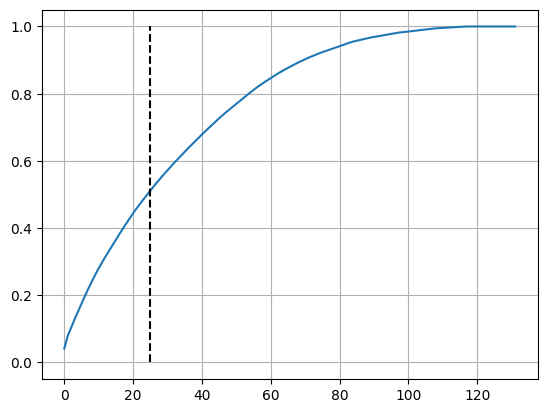

In [108]:
plt.plot(order)
plt.grid()
plt.vlines(x=[25],ymin=[0],ymax=[1],colors=['black'],linestyles=['dashed'])

In [109]:
order[25]

0.511655708308428

In [112]:
tosave=uniqueFeature.sort_values('score',ascending=False).head(26).copy().reset_index(drop=True)

In [114]:
dumpPickle("featureSelection26.pkl",tosave)